<a href="https://colab.research.google.com/github/rhks13/Closure-Prediction/blob/main/3%EB%B2%88_XGBoost_1%EB%85%84%EC%A0%84%EC%B2%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os
from glob import glob
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import xgboost as xgb
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,accuracy_score, f1_score
import sklearn
from sklearn.metrics import f1_score


## **한글설정**

In [ ]:
%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

!apt-get update -qq
!apt-get install fonts-nanum* -qq

sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

fm._rebuild()

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

sys_font number: 48
nanum_font number: 31
Python 3.7.13
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0
NanumGothic Eco


## **데이터 정리**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/통계 빅데이터 공모전/data/모델링용 최종본/이상_x_로그_x_원핫_o.csv')

In [ ]:
df.columns

Index(['Unnamed: 0', '행정동', '상권코드', '인허가일자', '사업장명', '시군구코드', '행정동코드', '소재지수정',
       '폐업여부', '사업기간',
       ...
       '시군구_은평구', '시군구_종로구', '시군구_중구', '시군구_중랑구', '생활인구_연령_대표_노년층',
       '생활인구_연령_대표_중장년층/자녀', '생활인구_연령_대표_청년층', '상주인구_연령_대표_노년층',
       '상주인구_연령_대표_중장년층/자녀', '상주인구_연령_대표_청년층'],
      dtype='object', length=103)

In [ ]:
df['인허가일자']=pd.to_datetime(df['인허가일자'])

In [ ]:
# #3년 인덱스
# inindex=df[df['인허가일자']<'2020-01-02'].index
# #2020년 이후 폐업 인덱스
# overindex=df.loc[df['인허가일자']>='2020-01-02'][df.loc[df['인허가일자']>='2020-01-02','폐업3년이내']==1].index
# ind=list(inindex)
# ond=list(overindex)
# #3년이내 폐업 최종 인덱스
# ind.extend(ond)
# len(ind)

In [ ]:
#1년 인덱스
inindex=df[df['인허가일자']<'2021-07-01'].index
#2020년 이후 폐업 인덱스
overindex=df.loc[df['인허가일자']>='2021-07-01'][df.loc[df['인허가일자']>='2021-07-01','폐업1년이내']==1].index
ind=list(inindex)
ond=list(overindex)
#1년이내 폐업(전체) 최종 인덱스
ind.extend(ond)
len(ind)

41714

In [ ]:
# #1년 인덱스
# af1ind=(df['인허가일자']>='2020-01-02').astype(int)+(df['인허가일자']<'2021-07-01').astype(int)==2
# inindex=df[af1ind].index
# #2020년 이후 폐업 인덱스
# overindex=df.loc[df['인허가일자']>='2021-07-01'][df.loc[df['인허가일자']>='2021-07-01','폐업1년이내']==1].index
# ind=list(inindex)
# ond=list(overindex)
# #1년이내 폐업(20이후) 최종 인덱스
# ind.extend(ond)
# len(ind)


In [ ]:
# #1년 인덱스
# inindex=df[df['인허가일자']<'2020-01-02'].index
# ind = inindex
# #1년이내 폐업(20이전) 인덱스
# len(ind)


In [ ]:
df=df[['Unnamed: 0', '상권코드', '인허가일자', '사업장명', '시군구코드', '행정동코드', '소재지수정',
       '폐업여부', '사업기간', '현재영업여부','행정동', '인허가분기', '인허가년도', '다중이용업소여부', '철도_역_수',
       '버스_터미널_수', '가맹여부', '코로나여부', '상권여부', '대학교_유무', '백화점_유무', '폐업1년이내',
       '폐업3년이내', '시설총규모', '추정임대료', '집객시설_수', '관공서_수', '은행_수', '슈퍼마켓_수', '극장_수',
       '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '총_생활인구_수', '아파트_단지_수', '의료기관_수',
       '교육기관_수', '생활인구_성별_비', '아파트_평당_가격', '총 상주인구 수', '상주인구_성별_비', '총 가구 수',
       '거주_유형_비', '점포당_매출_금액', '건수당_매출_금액', '점포수', '유사_업종_점포_수', '프랜차이즈_점포_수',
       '개업_율',  '폐업_률','선행종합지수', '소비자물가지수', '소비자심리지수', '중소기업대출금리', '업종분류_기타', '업종분류_분식전문점',
       '업종분류_양식음식점', '업종분류_일식음식점', '업종분류_중식음식점', '업종분류_치킨전문점', '업종분류_커피-음료',
       '업종분류_패스트푸드점', '업종분류_한식음식점', '업종분류_호프-간이주점', '상권변화_지표명_다이나믹',
       '상권변화_지표명_상권축소', '상권변화_지표명_상권확장', '상권변화_지표명_정체', '상권구분_코드명_골목상권',
       '상권구분_코드명_관광특구', '상권구분_코드명_발달상권', '상권구분_코드명_전통시장', '시군구_강남구', '시군구_강동구',
       '시군구_강북구', '시군구_강서구', '시군구_관악구', '시군구_광진구', '시군구_구로구', '시군구_금천구',
       '시군구_노원구', '시군구_도봉구', '시군구_동대문구', '시군구_동작구', '시군구_마포구', '시군구_서대문구',
       '시군구_서초구', '시군구_성동구', '시군구_성북구', '시군구_송파구', '시군구_양천구', '시군구_영등포구',
       '시군구_용산구', '시군구_은평구', '시군구_종로구', '시군구_중구', '시군구_중랑구', '생활인구_연령_대표_노년층',
       '생활인구_연령_대표_중장년층/자녀', '생활인구_연령_대표_청년층', '상주인구_연령_대표_노년층',
       '상주인구_연령_대표_중장년층/자녀', '상주인구_연령_대표_청년층']]

In [ ]:
df.iloc[:,10:].columns

Index(['행정동', '인허가분기', '인허가년도', '다중이용업소여부', '철도_역_수', '버스_터미널_수', '가맹여부',
       '코로나여부', '상권여부', '대학교_유무', '백화점_유무', '폐업1년이내', '폐업3년이내', '시설총규모',
       '추정임대료', '집객시설_수', '관공서_수', '은행_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수',
       '지하철_역_수', '버스_정거장_수', '총_생활인구_수', '아파트_단지_수', '의료기관_수', '교육기관_수',
       '생활인구_성별_비', '아파트_평당_가격', '총 상주인구 수', '상주인구_성별_비', '총 가구 수', '거주_유형_비',
       '점포당_매출_금액', '건수당_매출_금액', '점포수', '유사_업종_점포_수', '프랜차이즈_점포_수', '개업_율',
       '폐업_률', '선행종합지수', '소비자물가지수', '소비자심리지수', '중소기업대출금리', '업종분류_기타',
       '업종분류_분식전문점', '업종분류_양식음식점', '업종분류_일식음식점', '업종분류_중식음식점', '업종분류_치킨전문점',
       '업종분류_커피-음료', '업종분류_패스트푸드점', '업종분류_한식음식점', '업종분류_호프-간이주점',
       '상권변화_지표명_다이나믹', '상권변화_지표명_상권축소', '상권변화_지표명_상권확장', '상권변화_지표명_정체',
       '상권구분_코드명_골목상권', '상권구분_코드명_관광특구', '상권구분_코드명_발달상권', '상권구분_코드명_전통시장',
       '시군구_강남구', '시군구_강동구', '시군구_강북구', '시군구_강서구', '시군구_관악구', '시군구_광진구',
       '시군구_구로구', '시군구_금천구', '시군구_노원구', '시군구_도봉구', '시군구_동대문구', '시군구_동작구',
       '시군구_마포구', '시군구_서대문구', '시군구_서초구', '시군

In [ ]:

df.loc[:,'인허가년도'] = df['인허가년도'].astype(str)

In [ ]:
li = ['인허가년도']
for i in li:
  df=pd.get_dummies(data=df, columns = [i], prefix=i)

In [ ]:
colname = ['집객시설_수','관공서_수','은행_수','슈퍼마켓_수','극장_수','숙박_시설_수','지하철_역_수','버스_정거장_수','아파트_단지_수','의료기관_수','교육기관_수','점포수','유사_업종_점포_수','프랜차이즈_점포_수']

In [ ]:
df['철도_역_수'] = df['철도_역_수'].apply(lambda x:1 if x > 0 else 0)
df['버스_터미널_수'] = df['버스_터미널_수'].apply(lambda x:1 if x > 0 else 0)
df= df.rename(columns={'철도_역_수':'철도역_유무','버스_터미널_수':'버스터미널_유무'})

In [ ]:
for col in colname:
  df.loc[:,col] = df[col]/df['총_생활인구_수']

In [ ]:
colname = ['집객시설_수','관공서_수','은행_수','슈퍼마켓_수','극장_수','숙박_시설_수','지하철_역_수','버스_정거장_수','아파트_단지_수','의료기관_수','교육기관_수','점포수','유사_업종_점포_수','프랜차이즈_점포_수','총_생활인구_수']
df.loc[:,colname]

,집객시설_수,관공서_수,은행_수,슈퍼마켓_수,극장_수,숙박_시설_수,지하철_역_수,버스_정거장_수,아파트_단지_수,의료기관_수,교육기관_수,점포수,유사_업종_점포_수,프랜차이즈_점포_수,총_생활인구_수
0,0.000063,1.676718e-06,2.235624e-06,0.000000e+00,0.000003,2.962201e-05,1.676718e-06,6.147965e-06,0.000006,5.589059e-06,0.000000e+00,3.137210e-06,2.964048e-06,1.674332e-06,1789210.0
1,0.000016,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,3.489202e-06,0.000056,3.489202e-06,0.000000e+00,4.837061e-06,4.335170e-06,2.418530e-06,573197.0
2,0.000058,1.908228e-06,6.678797e-06,9.541138e-07,0.000000,3.816455e-06,9.541138e-07,1.240348e-05,0.000007,9.541138e-06,0.000000e+00,5.110793e-06,4.658749e-06,2.703208e-06,1048093.0
3,0.000005,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.389339e-06,0.000000e+00,1.792004e-06,0.000054,5.973348e-07,0.000000e+00,2.474839e-06,2.106418e-06,4.140409e-07,1674103.0
4,0.000006,6.723826e-07,3.361913e-07,0.000000e+00,0.000000,3.361913e-07,0.000000e+00,2.017148e-06,0.000033,1.344765e-06,0.000000e+00,1.708324e-06,1.561404e-06,5.410790e-07,2974497.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45697,0.000018,1.353796e-06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000051,2.707591e-06,0.000000e+00,4.888444e-06,4.121661e-06,0.000000e+00,738664.0
45698,0.000039,0.000000e+00,6.463949e-07,0.000000e+00,0.000000,0.000000e+00,1.939185e-06,1.098871e-05,0.000031,7.110343e-06,1.939185e-06,2.922861e-06,2.384473e-06,1.420275e-06,1547042.0
45699,0.000029,0.000000e+00,6.161268e-06,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.620951e-06,0.000051,6.161268e-06,0.000000e+00,4.270666e-06,4.689530e-06,0.000000e+00,649217.0
45700,0.000029,0.000000e+00,6.161268e-06,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.620951e-06,0.000051,6.161268e-06,0.000000e+00,7.901670e-06,6.730335e-06,2.997319e-06,649217.0


In [ ]:
df

,Unnamed: 0,상권코드,인허가일자,사업장명,시군구코드,행정동코드,소재지수정,폐업여부,사업기간,현재영업여부,...,생활인구_연령_대표_중장년층/자녀,생활인구_연령_대표_청년층,상주인구_연령_대표_노년층,상주인구_연령_대표_중장년층/자녀,상주인구_연령_대표_청년층,인허가년도_2017,인허가년도_2018,인허가년도_2019,인허가년도_2020,인허가년도_2021
0,0,2120037.0,2017-01-02,면면,11140.0,11140590.0,서울특별시 중구 을지로6가 18-12,1,569.0,0,...,0,1,1,0,0,1,0,0,0,0
1,1,2110112.0,2017-01-02,백채왕십리역점,11200.0,11200560.0,서울특별시 성동구 행당동 286-43,0,2005.0,1,...,0,0,0,1,0,1,0,0,0,0
2,2,2120052.0,2017-01-02,우리푸드,11200.0,11200690.0,서울특별시 성동구 성수동2가 289-5,0,2005.0,1,...,0,1,0,0,1,1,0,0,0,0
3,3,2110229.0,2017-01-02,일촌김밥분식,11230.0,11230650.0,서울특별시 동대문구 장안동 374-1,1,261.0,0,...,0,0,0,1,0,1,0,0,0,0
4,4,2110226.0,2017-01-02,마마포차,11230.0,11230650.0,서울특별시 동대문구 장안동 390-25,0,2005.0,1,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45697,45697,2111080.0,2021-12-30,주식회사더크레스트명일지점,11740.0,11740530.0,서울특별시 강동구 명일동 326-11,0,182.0,1,...,0,0,1,0,0,0,0,0,0,1
45698,45698,2111088.0,2021-12-30,곽만근족발슈바인학센강일고덕점,11740.0,11740560.0,서울특별시 강동구 강일동 679-3,0,182.0,1,...,0,0,0,1,0,0,0,0,0,1
45699,45699,2120193.0,2021-12-31,마일하이(Milehigh),11680.0,11680545.0,서울특별시 강남구 신사동 648-4,0,181.0,1,...,0,1,0,0,1,0,0,0,0,1
45700,45700,2120193.0,2021-12-31,우모크,11680.0,11680545.0,서울특별시 강남구 신사동 644-6,0,181.0,1,...,0,1,0,0,1,0,0,0,0,1


# **모델적합 (SMOTE)**

In [ ]:
import imblearn
print(imblearn.__version__)

import pandas as pd
from collections import Counter
from matplotlib import pyplot


# 필요 함수 정의
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()

0.8.1


col=['인허가분기', '인허가년도', '다중이용업소여부', '철도_역_수', '버스_터미널_수', '가맹여부', '코로나여부',
       '상권여부', '대학교_유무', '백화점_유무', '폐업1년이내', '폐업3년이내', '시설총규모', '추정임대료',
       '집객시설_수', '관공서_수', '은행_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수', '지하철_역_수',
       '버스_정거장_수', '총_생활인구_수', '아파트_단지_수', '의료기관_수', '교육기관_수', '생활인구_성별_비',
       '아파트_평당_가격', '총 상주인구 수', '상주인구_성별_비', '총 가구 수', '거주_유형_비', '점포당_매출_금액',
       '건수당_매출_금액', '점포수', '유사_업종_점포_수', '프랜차이즈_점포_수', '개업_율', '폐업_률',
       '선행종합지수', '소비자물가지수', '소비자심리지수', '중소기업대출금리', '업종분류_기타', '업종분류_분식전문점',
       '업종분류_양식음식점', '업종분류_일식음식점', '업종분류_중식음식점', '업종분류_치킨전문점', '업종분류_커피-음료',
       '업종분류_패스트푸드점', '업종분류_한식음식점', '업종분류_호프-간이주점', '상권변화_지표명_다이나믹',
       '상권변화_지표명_상권축소', '상권변화_지표명_상권확장', '상권변화_지표명_정체', '상권구분_코드명_골목상권',
       '상권구분_코드명_관광특구', '상권구분_코드명_발달상권', '상권구분_코드명_전통시장',  '생활인구_연령_대표_노년층',
       '생활인구_연령_대표_중장년층/자녀', '생활인구_연령_대표_청년층', '상주인구_연령_대표_노년층',
       '상주인구_연령_대표_중장년층/자녀', '상주인구_연령_대표_청년층']

In [ ]:
df.iloc[ind,11:].columns

Index(['인허가분기', '다중이용업소여부', '철도역_유무', '버스터미널_유무', '가맹여부', '코로나여부', '상권여부',
       '대학교_유무', '백화점_유무', '폐업1년이내', '폐업3년이내', '시설총규모', '추정임대료', '집객시설_수',
       '관공서_수', '은행_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수', '지하철_역_수', '버스_정거장_수',
       '총_생활인구_수', '아파트_단지_수', '의료기관_수', '교육기관_수', '생활인구_성별_비', '아파트_평당_가격',
       '총 상주인구 수', '상주인구_성별_비', '총 가구 수', '거주_유형_비', '점포당_매출_금액', '건수당_매출_금액',
       '점포수', '유사_업종_점포_수', '프랜차이즈_점포_수', '개업_율', '폐업_률', '선행종합지수', '소비자물가지수',
       '소비자심리지수', '중소기업대출금리', '업종분류_기타', '업종분류_분식전문점', '업종분류_양식음식점',
       '업종분류_일식음식점', '업종분류_중식음식점', '업종분류_치킨전문점', '업종분류_커피-음료', '업종분류_패스트푸드점',
       '업종분류_한식음식점', '업종분류_호프-간이주점', '상권변화_지표명_다이나믹', '상권변화_지표명_상권축소',
       '상권변화_지표명_상권확장', '상권변화_지표명_정체', '상권구분_코드명_골목상권', '상권구분_코드명_관광특구',
       '상권구분_코드명_발달상권', '상권구분_코드명_전통시장', '시군구_강남구', '시군구_강동구', '시군구_강북구',
       '시군구_강서구', '시군구_관악구', '시군구_광진구', '시군구_구로구', '시군구_금천구', '시군구_노원구',
       '시군구_도봉구', '시군구_동대문구', '시군구_동작구', '시군구_마포구', '시군구_서대문구', '시군구_서초구',
       '시군구_성동구', '시군구_성북구

In [ ]:
df_input = df.iloc[ind, 12:] #인허가분기도 제외
#df_input =df_input.loc[:,col] #시군구 제외용

In [ ]:
y = df_input.pop('폐업1년이내')
df_input.pop('폐업3년이내')

X = df_input

In [ ]:
print(X.shape, y.shape)

(41714, 93) (41714,)


Class=0, n=36598 (49.010%)
Class=1, n=38077 (50.990%)


Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


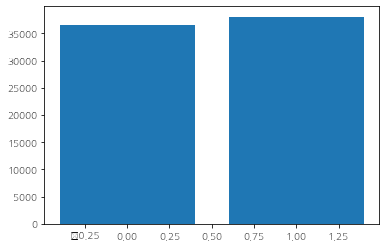

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
X_resampled, y_resampled = ADASYN(random_state=0).fit_resample(X, y)
count_and_plot(y_resampled)

In [ ]:
print(X_resampled.shape, y_resampled.shape)

(74675, 93) (74675,)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.4,random_state=11)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.75,random_state=11)
print(X_train.shape, X_val.shape, X_test.shape)

(44805, 93) (7467, 93) (22403, 93)


In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'map',
         'early_stoppings' : 100, 
         'subsample' : 0.8,
          }

In [ ]:
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = 400, 
                        early_stopping_rounds = 100, evals=[(dtrain,'train'),(dval,'eval')])

[0]	train-map:0.773606	eval-map:0.776642
Multiple eval metrics have been passed: 'eval-map' will be used for early stopping.

Will train until eval-map hasn't improved in 100 rounds.
[1]	train-map:0.854994	eval-map:0.858288
[2]	train-map:0.885344	eval-map:0.887001
[3]	train-map:0.916168	eval-map:0.918345
[4]	train-map:0.90487	eval-map:0.907185
[5]	train-map:0.909865	eval-map:0.912493
[6]	train-map:0.922529	eval-map:0.925643
[7]	train-map:0.929028	eval-map:0.931768
[8]	train-map:0.933926	eval-map:0.937169
[9]	train-map:0.933809	eval-map:0.936595
[10]	train-map:0.940366	eval-map:0.943214
[11]	train-map:0.941979	eval-map:0.945186
[12]	train-map:0.945658	eval-map:0.948087
[13]	train-map:0.946171	eval-map:0.948614
[14]	train-map:0.951772	eval-map:0.953991
[15]	train-map:0.952503	eval-map:0.95462
[16]	train-map:0.950803	eval-map:0.953023
[17]	train-map:0.951116	eval-map:0.953445
[18]	train-map:0.954792	eval-map:0.956647
[19]	train-map:0.957484	eval-map:0.959427
[20]	train-map:0.957973	eval-m

In [ ]:
xgb_pred = xgb_model.predict(dtest)
y_preds = [1 if x>0.5 else 0 for x in xgb_pred]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
from sklearn.metrics import f1_score
print('평균 정확도:', accuracy_score(y_test, y_preds))
print('평균 f1-score:', f1_score(y_test, y_preds))
print('평균 roc:', roc_auc_score(y_test, y_preds))

[[11044    92]
 [ 1390  9877]]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11136
           1       0.99      0.88      0.93     11267

    accuracy                           0.93     22403
   macro avg       0.94      0.93      0.93     22403
weighted avg       0.94      0.93      0.93     22403

평균 정확도: 0.933848145337678
평균 f1-score: 0.9302128461103786
평균 roc: 0.9341846873281651


In [ ]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5, shuffle=True, random_state = 50)

In [ ]:
# accuracy_history=[]
# f1_score_history=[]
# roc_history=[]
# for train_index, test_index in kf.split(X_resampled):
#   X_train,X_test = X_resampled.iloc[train_index,:],X_resampled.iloc[test_index,:]
#   y_train,y_test = y_resampled.iloc[train_index],y_resampled[test_index]
#   dtrain = xgb.DMatrix(data=X_train, label=y_train)
#   dtest = xgb.DMatrix(data=X_test, label=y_test)

#   params = {'max_depth' : 3,
#          'eta' : 0.1, 
#          'objective' : 'binary:logistic',
#          'eval_metric' : 'map',
#          'early_stoppings' : 100, 
#          'subsample' : 0.8,
#           }

#   xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = 400, 
#                         early_stopping_rounds = 100, evals=[(dtrain,'train')])
 
                        
#   xgb_pred = xgb_model.predict(dtest)
#   y_preds = [1 if x>0.5 else 0 for x in xgb_pred]
#   accuracy_history.append(accuracy_score(y_test, y_preds))
#   f1_score_history.append(f1_score(y_test, y_preds))
#   roc_history.append(roc_auc_score(y_test, y_preds))
# print('평균 정확도:', np.mean(accuracy_history))
# print('평균 f1score:', np.mean(f1_score_history))
# print('평균 roc:', np.mean(roc_history))


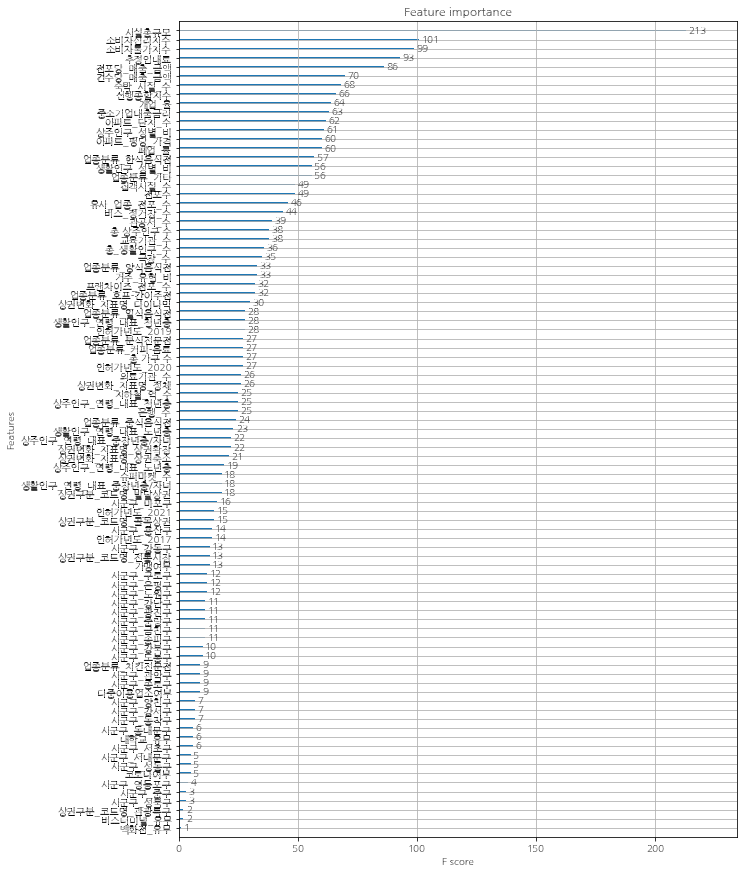

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,15))
plot_importance(xgb_model, ax=ax)

## **SHAP**

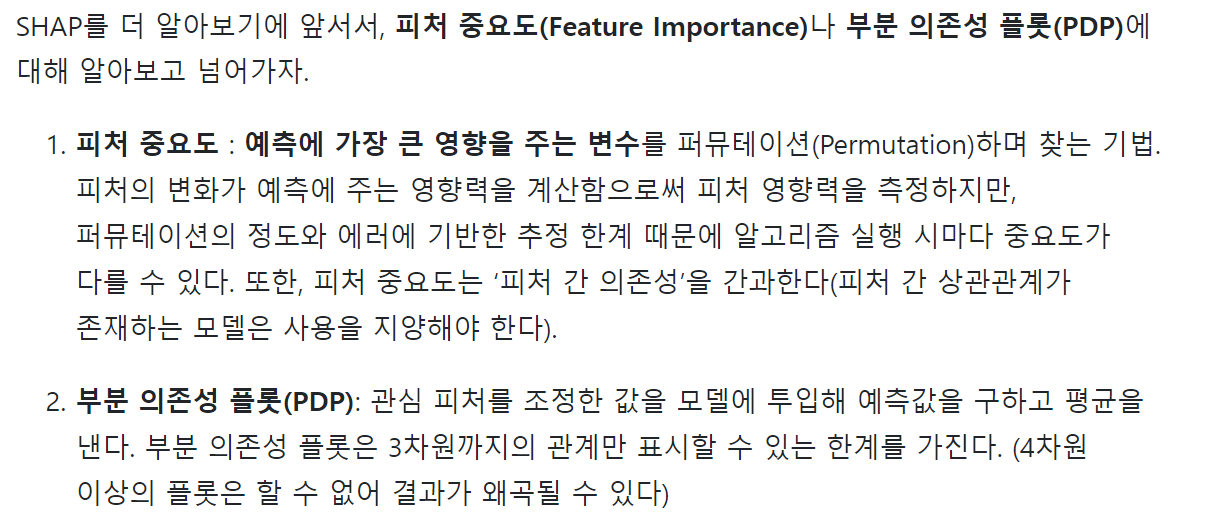

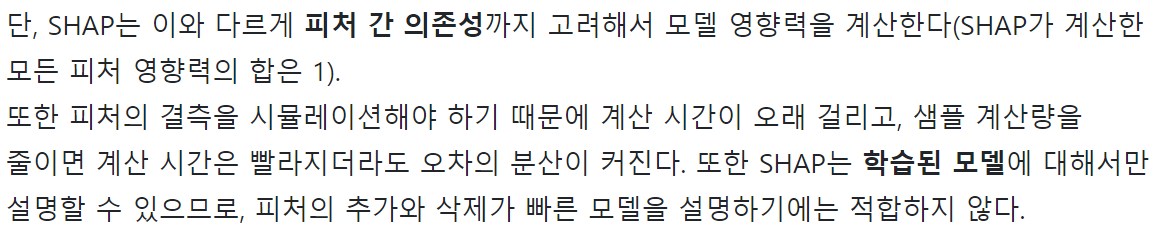

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap
import shap

In [ ]:
explainer = shap.Explainer(xgb_model)

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


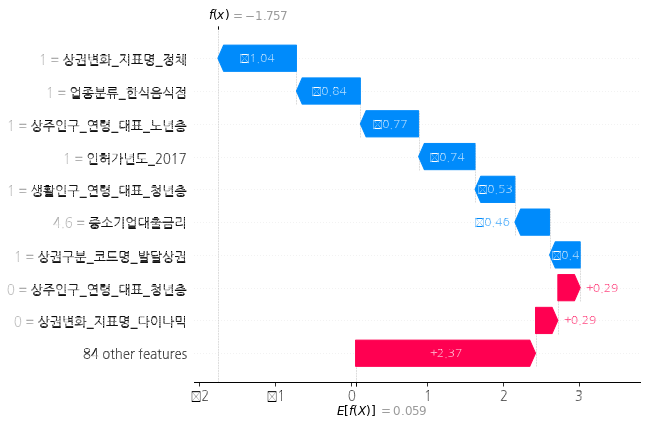

In [ ]:
shap_values = explainer(X_resampled)
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.TreeExplainer(xgb_model).shap_values(X_resampled)

array([[ 2.1945979e-02,  0.0000000e+00, -1.3085692e-04, ...,
         1.4590769e-01,  1.5257730e-01,  8.1236631e-02],
       [ 2.0600261e-02,  0.0000000e+00, -1.3085692e-04, ...,
         1.6588874e-01,  1.5182710e-01,  8.1877343e-02],
       [ 1.9610832e-02,  0.0000000e+00, -9.4284987e-05, ...,
         1.5717976e-01,  1.5845267e-01,  7.6710679e-02],
       ...,
       [ 2.0570219e-02,  0.0000000e+00, -1.1957764e-04, ...,
         2.2107638e-01,  1.6734293e-01,  2.4026725e-02],
       [ 1.9057672e-02,  0.0000000e+00, -1.1957764e-04, ...,
         2.3223215e-01,  1.4211389e-01, -1.7955044e-01],
       [ 1.9057672e-02,  0.0000000e+00, -1.1957764e-04, ...,
         2.3223215e-01,  1.4211389e-01, -1.7955044e-01]], dtype=float32)

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


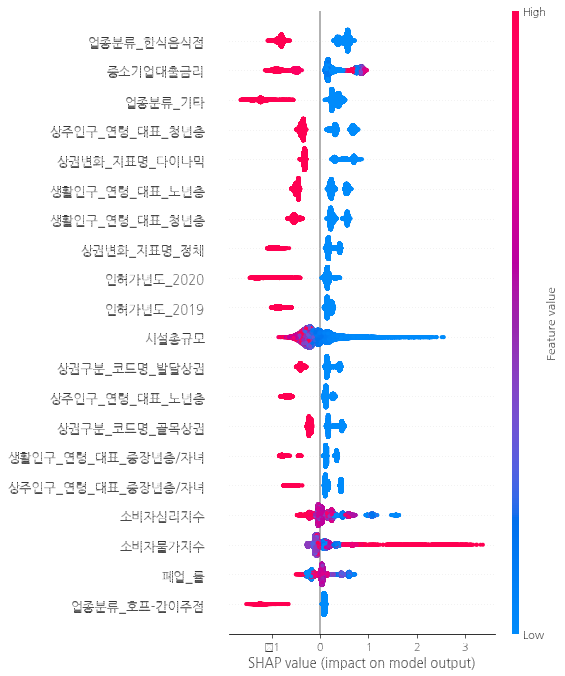

In [ ]:
shap.summary_plot(shap_values, X_resampled)

모든 고객 -> 각 행마다 점 하나

점의 x축위치 -> 모형의 폐업예측에 해당 
변수가 미치는 영향력

점의 색-> 고객의 해당 변숫값

점이 쌓여있는 정도 -> 빈도

[해석]

시설총규모 커(high value) -> 예측된 폐업여부 감소시켜 (0)


시설총규모 작아(low value) -> 예측된 폐업여부 증가시켜 (1) 

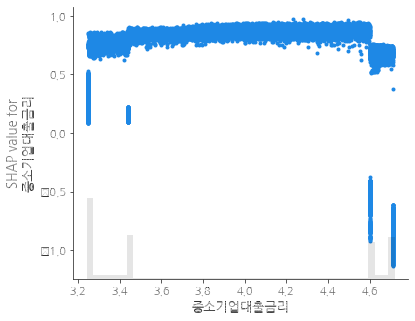

In [ ]:
shap.plots.scatter(shap_values[:,'중소기업대출금리'])

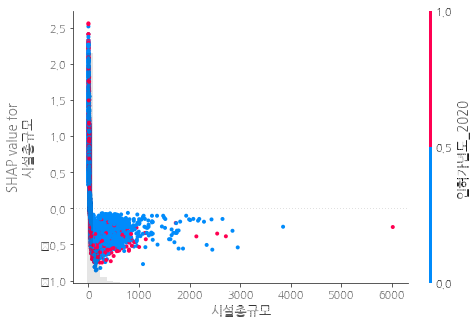

In [ ]:
shap.plots.scatter(shap_values[:,'시설총규모'], color=shap_values)

x축 -> 시설 총규모

y축 -> 시설 총규모 변수가 폐엽여부에 대한 로그오즈를 얼마나 바꾸는지에 대한것

xgboost모형이 잡아낸 잠재적 여부에 대한 시설총규모의 명확한 영향력 볼 수 있음

색깔은 자기들이 잘 구분지어 줄수있는 변수 아무나 데리고 와서 구분


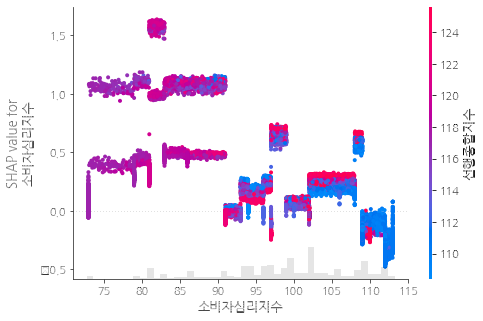

In [ ]:
shap.plots.scatter(shap_values[:,'소비자심리지수'], color=shap_values)

Glyph 8722 missing from current font.
Glyph 8722 missing from current font.


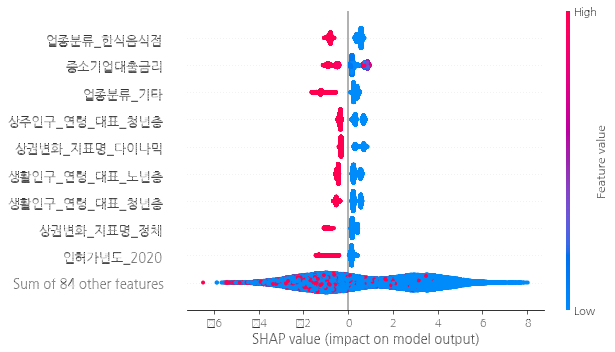

In [ ]:
shap.plots.beeswarm(shap_values)

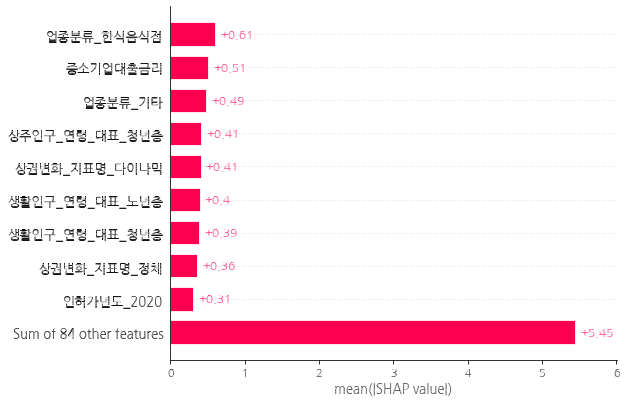

In [ ]:
shap.plots.bar(shap_values)

## **LIME**

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)

In [ ]:
#해당코드에서 타겟을 달리하며 모델 적합
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import os
from glob import glob
import pickle
import xgboost as xgb
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,accuracy_score, f1_score
import sklearn
from sklearn.metrics import f1_score

##데이터 정리
df = pd.read_csv('/content/drive/MyDrive/통계 빅데이터 공모전/data/모델링용 최종본/이상_x_로그_x_원핫_o.csv')
df['인허가일자']=pd.to_datetime(df['인허가일자'])
# #3년 인덱스
# inindex=df[df['인허가일자']<'2020-01-02'].index
# #2020년 이후 폐업 인덱스
# overindex=df.loc[df['인허가일자']>='2020-01-02'][df.loc[df['인허가일자']>='2020-01-02','폐업3년이내']==1].index
# ind=list(inindex)
# ond=list(overindex)
# #3년이내 폐업 최종 인덱스
# ind.extend(ond)
# len(ind)
#1년 인덱스
inindex=df[df['인허가일자']<'2021-07-01'].index
#2020년 이후 폐업 인덱스
overindex=df.loc[df['인허가일자']>='2021-07-01'][df.loc[df['인허가일자']>='2021-07-01','폐업1년이내']==1].index
ind=list(inindex)
ond=list(overindex)
#1년이내 폐업(전체) 최종 인덱스
ind.extend(ond)
len(ind)
df=df[['Unnamed: 0', '상권코드', '인허가일자', '사업장명', '시군구코드', '행정동코드', '소재지수정',
       '폐업여부', '사업기간', '현재영업여부','행정동', '인허가분기', '인허가년도', '다중이용업소여부', '철도_역_수',
       '버스_터미널_수', '가맹여부', '코로나여부', '상권여부', '대학교_유무', '백화점_유무', '폐업1년이내',
       '폐업3년이내', '시설총규모', '추정임대료', '집객시설_수', '관공서_수', '은행_수', '슈퍼마켓_수', '극장_수',
       '숙박_시설_수', '지하철_역_수', '버스_정거장_수', '총_생활인구_수', '아파트_단지_수', '의료기관_수',
       '교육기관_수', '생활인구_성별_비', '아파트_평당_가격', '총 상주인구 수', '상주인구_성별_비', '총 가구 수',
       '거주_유형_비', '점포당_매출_금액', '건수당_매출_금액', '점포수', '유사_업종_점포_수', '프랜차이즈_점포_수',
       '개업_율',  '폐업_률','선행종합지수', '소비자물가지수', '소비자심리지수', '중소기업대출금리', '업종분류_기타', '업종분류_분식전문점',
       '업종분류_양식음식점', '업종분류_일식음식점', '업종분류_중식음식점', '업종분류_치킨전문점', '업종분류_커피-음료',
       '업종분류_패스트푸드점', '업종분류_한식음식점', '업종분류_호프-간이주점', '상권변화_지표명_다이나믹',
       '상권변화_지표명_상권축소', '상권변화_지표명_상권확장', '상권변화_지표명_정체', '상권구분_코드명_골목상권',
       '상권구분_코드명_관광특구', '상권구분_코드명_발달상권', '상권구분_코드명_전통시장', '시군구_강남구', '시군구_강동구',
       '시군구_강북구', '시군구_강서구', '시군구_관악구', '시군구_광진구', '시군구_구로구', '시군구_금천구',
       '시군구_노원구', '시군구_도봉구', '시군구_동대문구', '시군구_동작구', '시군구_마포구', '시군구_서대문구',
       '시군구_서초구', '시군구_성동구', '시군구_성북구', '시군구_송파구', '시군구_양천구', '시군구_영등포구',
       '시군구_용산구', '시군구_은평구', '시군구_종로구', '시군구_중구', '시군구_중랑구', '생활인구_연령_대표_노년층',
       '생활인구_연령_대표_중장년층/자녀', '생활인구_연령_대표_청년층', '상주인구_연령_대표_노년층',
       '상주인구_연령_대표_중장년층/자녀', '상주인구_연령_대표_청년층']]
df.loc[:,'인허가년도'] = df['인허가년도'].astype(str)
li = ['인허가년도']
for i in li:
  df=pd.get_dummies(data=df, columns = [i], prefix=i)
colname = ['집객시설_수','관공서_수','은행_수','슈퍼마켓_수','극장_수','숙박_시설_수','지하철_역_수','버스_정거장_수','아파트_단지_수','의료기관_수','교육기관_수','점포수','유사_업종_점포_수','프랜차이즈_점포_수']
df['철도_역_수'] = df['철도_역_수'].apply(lambda x:1 if x > 0 else 0)
df['버스_터미널_수'] = df['버스_터미널_수'].apply(lambda x:1 if x > 0 else 0)
df= df.rename(columns={'철도_역_수':'철도역_유무','버스_터미널_수':'버스터미널_유무'})
for col in colname:
  df.loc[:,col] = df[col]/df['총_생활인구_수']
colname = ['집객시설_수','관공서_수','은행_수','슈퍼마켓_수','극장_수','숙박_시설_수','지하철_역_수','버스_정거장_수','아파트_단지_수','의료기관_수','교육기관_수','점포수','유사_업종_점포_수','프랜차이즈_점포_수','총_생활인구_수']

## 모델 오버샘플링 & 적합
import imblearn
print(imblearn.__version__)

import pandas as pd
from collections import Counter
from matplotlib import pyplot


# 필요 함수 정의
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()
df_input = df.iloc[ind, 12:] #인허가분기도 제외    
y = df_input.pop('폐업1년이내')
df_input.pop('폐업3년이내')

X = df_input
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
X_resampled, y_resampled = ADASYN(random_state=0).fit_resample(X, y)
count_and_plot(y_resampled)
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.4,random_state=11)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size=0.75,random_state=11)
print(X_train.shape, X_val.shape, X_test.shape)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)
params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'map',
         'early_stoppings' : 100, 
         'subsample' : 0.8,
          }
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = 400, 
                        early_stopping_rounds = 100, evals=[(dtrain,'train'),(dval,'eval')])
xgb_pred = xgb_model.predict(dtest)
y_preds = [1 if x>0.5 else 0 for x in xgb_pred]
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
from sklearn.metrics import f1_score
print('평균 정확도:', accuracy_score(y_test, y_preds))
print('평균 f1-score:', f1_score(y_test, y_preds))
print('평균 roc:', roc_auc_score(y_test, y_preds))
from sklearn.model_selection import KFold 
kf = KFold(n_splits=5, shuffle=True, random_state = 50)
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,15))
plot_importance(xgb_model, ax=ax)

##SHAP
!pip install shap
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_resampled)
shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, X_resampled)
shap.plots.scatter(shap_values[:,'중소기업대출금리'])
shap.plots.scatter(shap_values[:,'시설총규모'], color=shap_values)
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)